# Assignment 2: Segmentation from Superpixels

Name: **Gokul Hari**

UID:  **17430646**

Link to Google Drive : **View-only Link to Notebook Here (make sure it works)**

Please submit a PDF containing all outputs to gradescope by **November 30, 3:30pm**




The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 



Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Data
First, we download the MSRC labeled imaged database.

In [1]:
# !wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
# !unzip --qq msrc_objcategimagedatabase_v1.zip

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.

In [2]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg, plot = True, title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    if plot:
        plot_image(seg_img,title)
    else:
        return seg_img


Before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

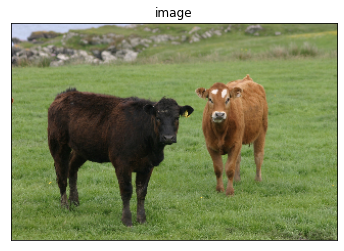

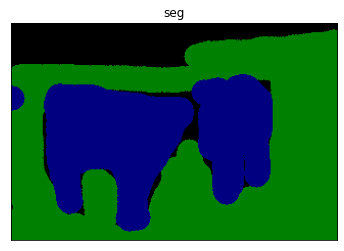

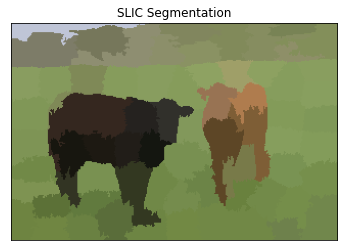

In [3]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [4]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
from tqdm import tqdm
from glob import glob
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [5]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]},
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]}]


# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.

rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = i['rgb_values']



## Question 1: Superpixel Dataset (30 points) 

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>




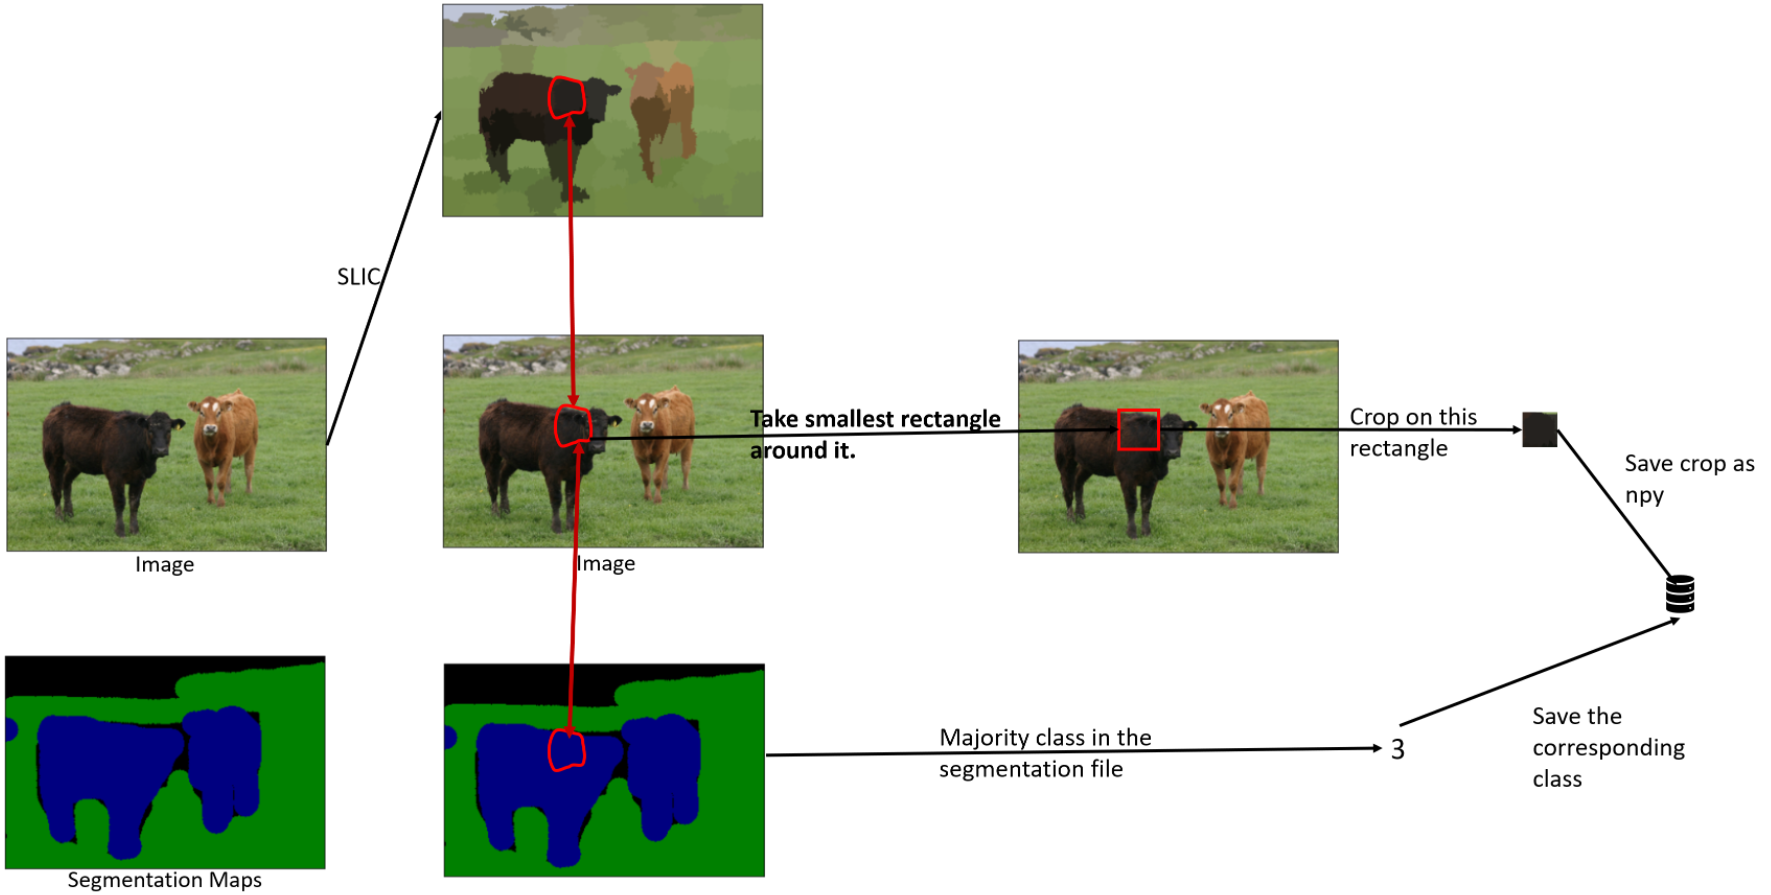

In [6]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

# if os.path.exists('./datasets/train.txt'):
#     os.remove('./datasets/train.txt')

# for filename in os.listdir(msrc_directory):
#     # Your code 
#     pass

import pandas as pd
from sklearn.model_selection import train_test_split

def foldercheck(Savepath):
    if(not (os.path.isdir(Savepath))):
        print(Savepath, "  was not present, creating the folder...")
        os.makedirs(Savepath)

# SETUP FILES
imfiles = sorted(glob(msrc_directory+'/*_s.bmp'))
gtfiles = sorted(glob(msrc_directory+'/*_s_GT.bmp'))
assert len(imfiles) == len(gtfiles), f"Datasize mismatch GTfiles: {len(gtfiles)} imfiles: {len(imfiles)}"
N = len(gtfiles)
N_SEG = 100

train_imfiles, test_imfiles, train_gtfiles, test_gtfiles = train_test_split(imfiles, gtfiles, test_size=0.2, random_state=42)
print(len(train_imfiles), len(test_imfiles))

192 48


In [7]:
##############################################################################################################################
#########################################  SLIC PatchExtraction Functions ####################################################
##############################################################################################################################

def segBBox(slicmap, Ci):
    """ Returns the bounding boxes of a given label Ci in the segmented map
    Args:
        slicmap : slic segmented map of shape H,W
        Ci : label of  choice in the segmentation map
    """
    h,w = slicmap.shape
    Ci_indices = np.where(slicmap == Ci)
    n_dilate = 3
    if len(Ci_indices[0]):
        # find the patch boundaries -- defines a rectangle
        y_min, y_max = min(Ci_indices[0]), max(Ci_indices[0])
        x_min, x_max = min(Ci_indices[1]), max(Ci_indices[1]) 

        # dilate the rectangle boundaries
        x_min, x_max = max(0, x_min - n_dilate), min(w, x_max + n_dilate)        
        y_min, y_max = max(0, y_min - n_dilate), min(h, y_max + n_dilate)
        return (y_min, x_min), (y_max, x_max)
    else:
        # print(f"found no slic segments for {Ci}")
        return None

def BBoxclass(gt_Ci,rgb_2_label, N_CLASSES =10):
  """ Returns the class-label of bbox patch 
  Args:
      gt_Ci ([type]): patch/bbox segment
      N_CLASSES : number of classes in the dataset Defaults to 10.
  """
  labeldict = {}
  labels = np.unique(list(rgb_2_label.values()) )
  for l in labels:
      labeldict[l] = 0

  h,w = gt_Ci.shape[:2]
  for y in range(h):
      for x in range(w):
        color = tuple(gt_Ci[y,x])
        label = rgb_2_label.get(color, -1) # void label if color key not found
        labeldict[label] +=1

  return max(labeldict, key=labeldict.get)


def extractPatches( imfiles, gtfiles,rgb_2_label, mode= 'train', n_classes=10, saveflag=True):
    """ Extracts the patches and saves as npy file 
    Args:
        imfiles : image files
        gtfiles : groundtruth segmentation files
        mode : train/test
    """
    # read the root and 
    root, _ = os.path.split(imfiles[0])
    foldercheck(root +f'/{mode}/') 

    metafile = []
    for i in tqdm(range(len(imfiles))):
        # read image and obtain slic segments
        image = cv2.imread(imfiles[i])[:,:,::-1]
        groundtruth = cv2.imread(gtfiles[i])[:,:,::-1]
        slicmap = slic(image, n_segments=N_SEG, compactness=10)

        nonecounter = 0
        for Ci in np.unique(slicmap):
            bbox = segBBox(slicmap, Ci)
            if bbox is  None or ((bbox[1][0]-bbox[0][0])<5 or (bbox[1][1]-bbox[0][1])<5):
                nonecounter+=1
                continue
            
            (y1,x1), (y2,x2) = bbox
            imCi = image[y1:y2, x1:x2, :] # image patch containing segment Ci
            if imCi.shape[0] <5 or imCi.shape[1] < 5:
                continue
            sp_i = groundtruth[y1:y2, x1:x2, :] # seg groundtruth patch containing slic-segment Ci
            sp_i_label = BBoxclass(sp_i, rgb_2_label, N_CLASSES = n_classes) # find the argmax-class-label in this patch

            if saveflag:
                _, imfilename = os.path.split(imfiles[i])
                savefilename = root +f'/{mode}/' + imfilename.replace('.bmp', f'_C{Ci}_.npy')
                np.save(savefilename, imCi)            
                metafile.append([savefilename, sp_i_label])
            # else:
            #     yield sp_i, sp_i_label

        if nonecounter:
            print(f"{nonecounter}/{N_SEG} no.of empty segments in {imfilename}")
    if saveflag:
        metadf = pd.DataFrame(metafile, columns=['path', 'label'])
        metadf.to_csv(f'{root}/{mode}meta.csv')


##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################

# UNCOMMENT TO EXTRACT PATCHES
# extractPatches(test_imfiles, test_gtfiles, rgb_2_label, mode= 'test', saveflag=True)
# extractPatches(train_imfiles, train_gtfiles, rgb_2_label, mode= 'train', saveflag=True)

In [8]:
# Check value counts of generated patches 
testdf = pd.read_csv(f'{msrc_directory}/trainmeta.csv')
print("test df value counts \n", testdf.label.value_counts())
traindf = pd.read_csv(f'{msrc_directory}/testmeta.csv')
print("train df value counts \n", traindf.label.value_counts())

test df value counts 
 -1    3294
 1    2684
 4    1492
 0    1148
 7     755
 2     631
 3     627
 6     328
 5     293
 8     244
Name: label, dtype: int64
train df value counts 
 -1    988
 1    746
 4    314
 0    276
 6    158
 7    139
 2    133
 3    105
 5     85
 8     70
Name: label, dtype: int64


((107, 122), (207, 227)) ... 29
(100, 105, 3)
Label : 1


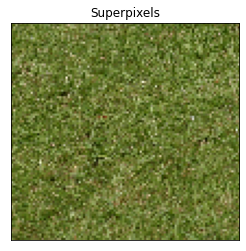

In [9]:
# [UNIT TEST] -  FOR PATCH-LABEL EXTRACTION

i=0 # change image index

image = cv2.imread(test_imfiles[i])[:, :, ::-1]
groundtruth = cv2.imread(test_gtfiles[i])[:, :, ::-1]
slicmap = slic(image, n_segments=N_SEG, compactness=10)
        
Ci = np.unique(slicmap)[29] # change superpixel index
bbox = segBBox(slicmap, Ci)

print( f"{bbox} ... {Ci}"  )
(y1,x1), (y2,x2) = bbox

# image patch containing segment Ci
imCi = image[y1:y2, x1:x2, :] 
print(imCi.shape)
# seg groundtruth patch containing slic-segment Ci
sp_i = groundtruth[y1:y2, x1:x2, :] 
# find the argmax-class-label in this patch
sp_i_label = BBoxclass(sp_i,rgb_2_label, N_CLASSES = 10) 

print(f"Label : {sp_i_label}")
superpixel_plot(image, slicmap)
plt.imshow(sp_i)
plt.imshow(imCi)


Now, we can define the dataset and dataloader.

In [9]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


In [ ]:
##############################################################################################################################
###################################################  Dataloader Functions ####################################################
##############################################################################################################################
# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.


class SegmentationData(data.Dataset):
    def __init__(self, path, mode, transform=None):
      self.df = pd.read_csv(f'{path}/{mode}meta.csv', skiprows=1, header=None)
      print( f"{mode} loader length {len(self.df)} " )
      self.transform = transform
            
    def __len__(self):
      return len(self.df)
    
    def __getitem__(self, index):
      # load images and label
      image = np.load(self.df.iloc[index, 1], allow_pickle=True)
      label = int(self.df.iloc[index, 2])
      # apply transform      
      if self.transform:
        image = self.transform(image)
      return image, label+1 # shift all labels by +1
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),   #transforms.RandomCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])


##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################
# load the data
batch_size = 10
trainset = SegmentationData(path =msrc_directory,  mode = 'train', transform=custom_transforms)
valset = SegmentationData(path =msrc_directory,  mode = 'test', transform=custom_transforms)

## IMPORTANT

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

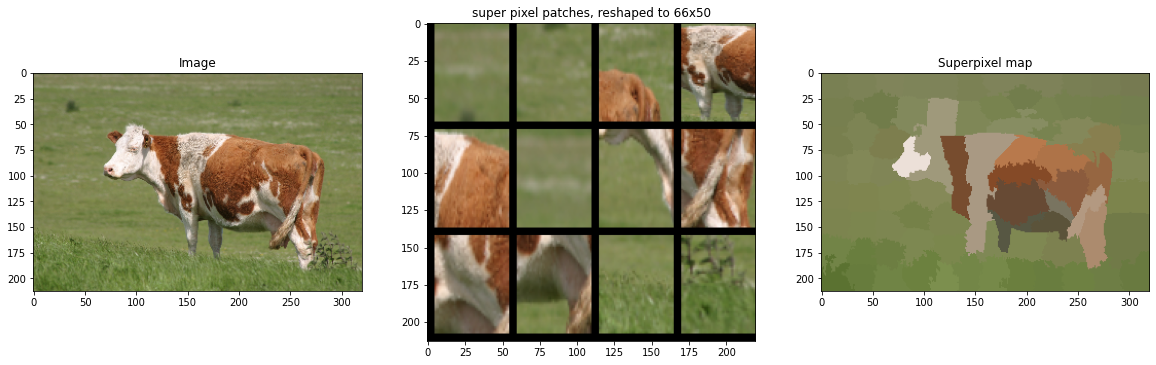

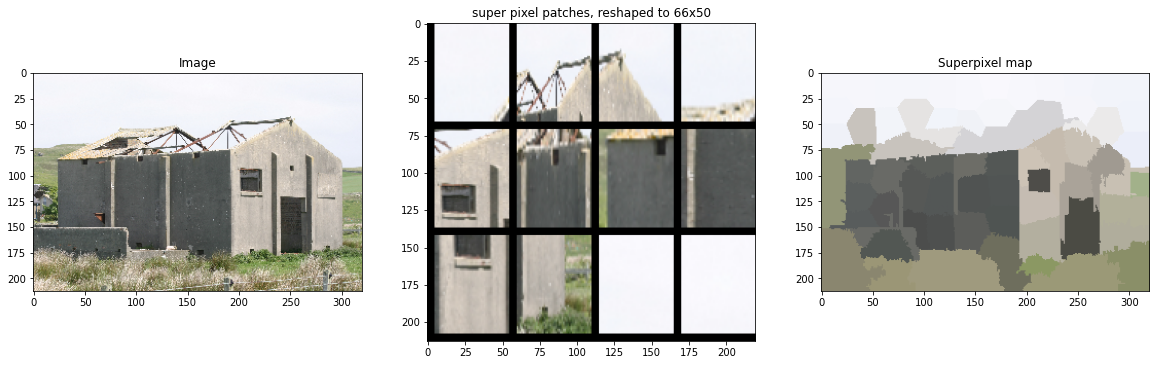

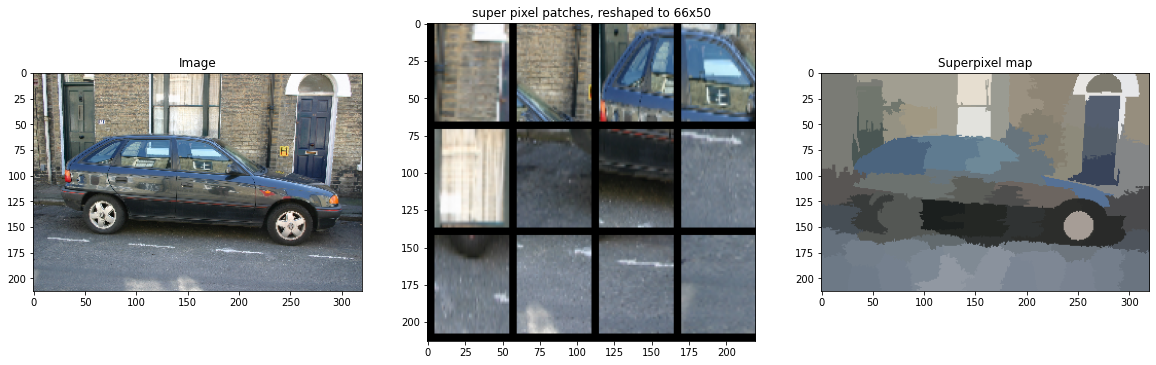

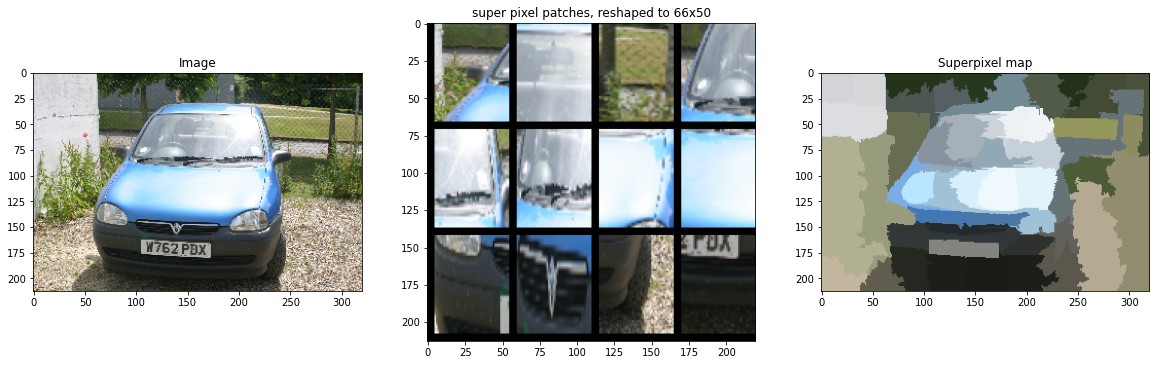

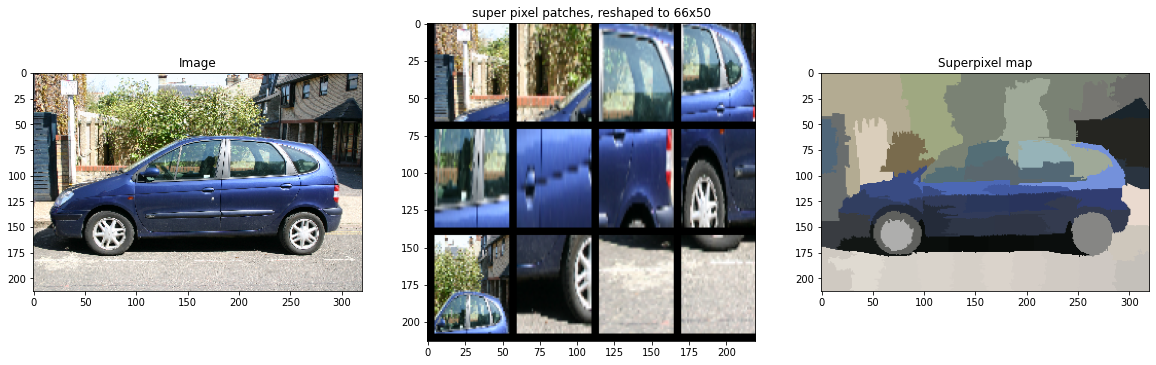

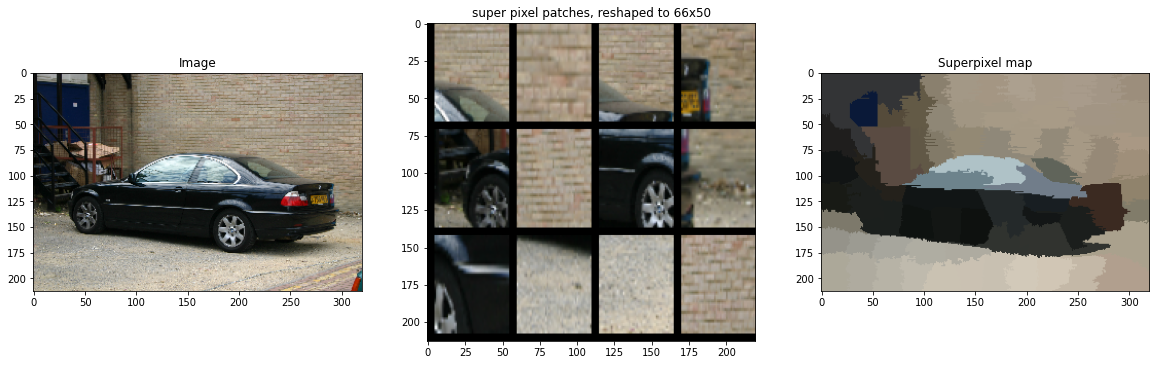

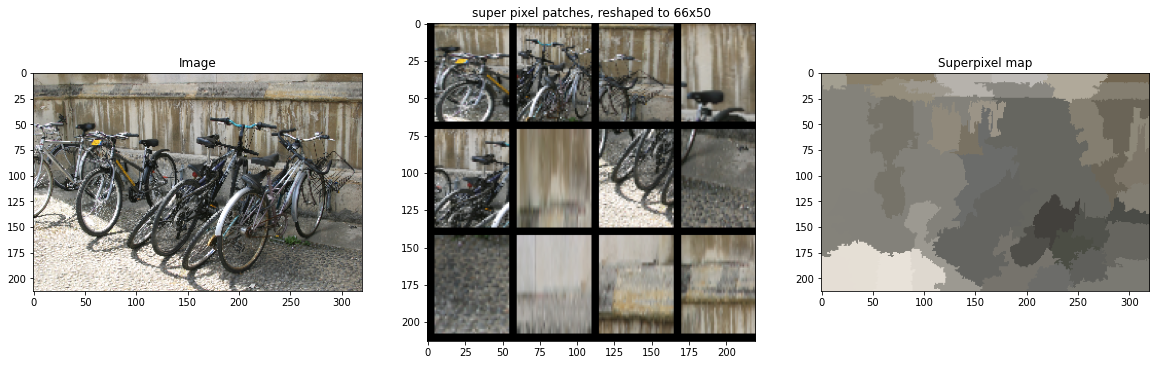

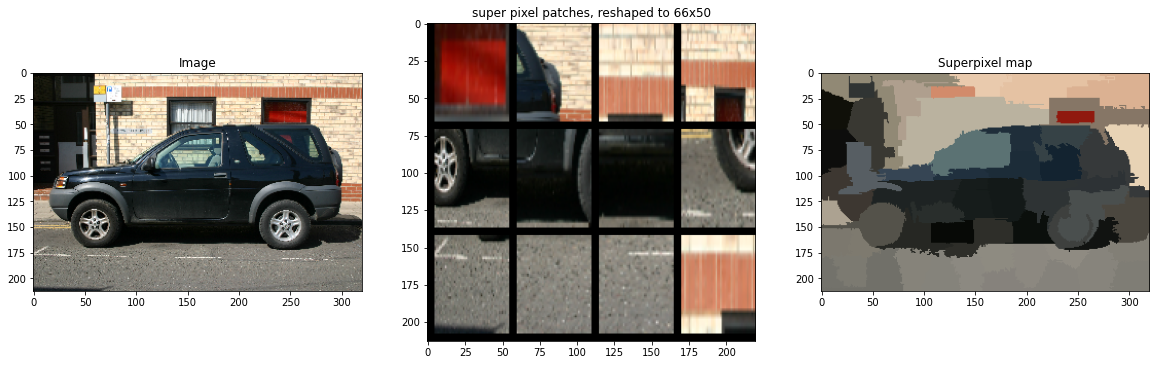

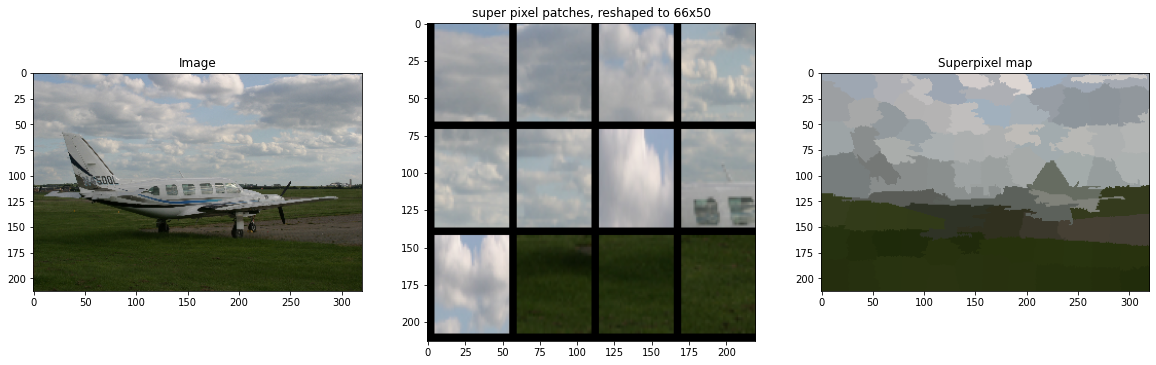

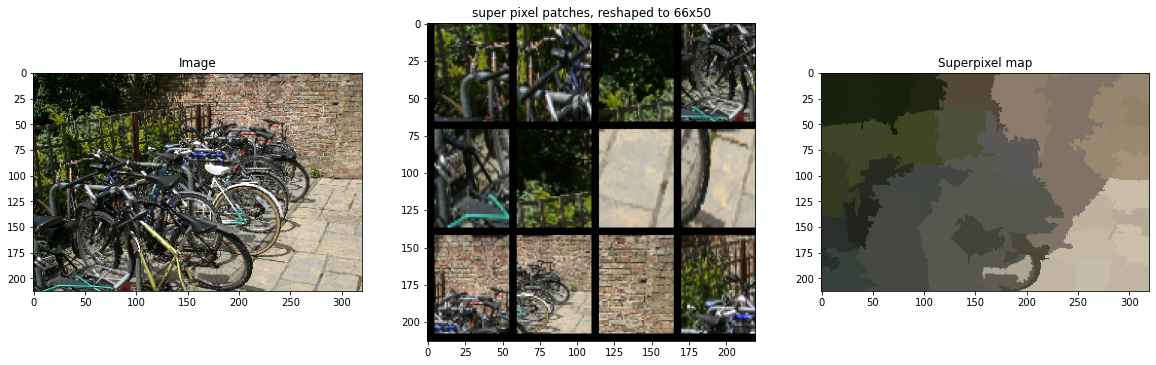

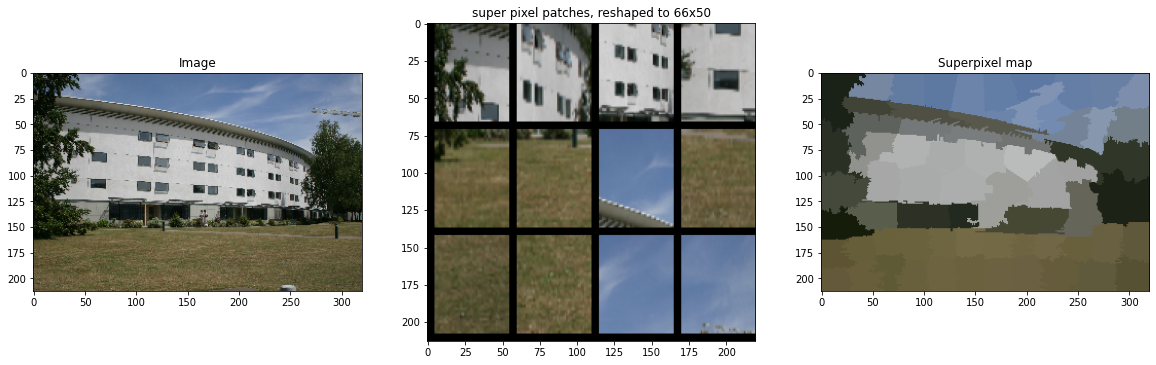

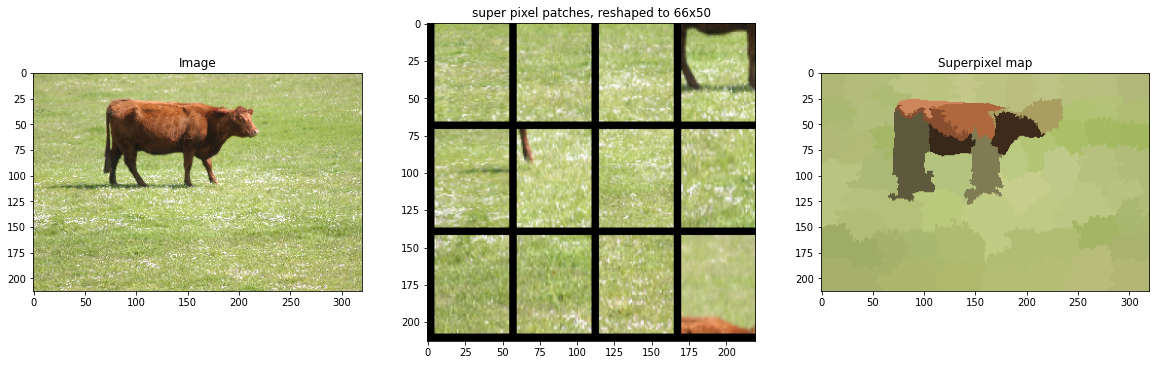

In [23]:
### YOUR CODE TO PLOT 12 images (GT + superpixel map + first 10 superpixels) ###

##############################################################################################################################
############################################## Visualization  Functions ######################################################
##############################################################################################################################
import random
def retrievePatches(imfilepath, folder):
    """
    Reads and returns all the patches corresponding to an image
    """
    _, prefix = os.path.split(imfilepath)
    patchname = folder+f'/{prefix[:-4]}'
    return glob(patchname +'*.npy')

def patchGrid_vis(patches):
    """
    returns a grid of randomly sampled 12 patches corresponding to an image
    """
    patch_samples = sorted(random.sample(patches, 12))
    
    patchlist = []
    hbar = np.zeros((66, 5, 3), dtype=np.uint8); wbar = np.zeros((5, 220, 3), dtype=np.uint8)
    for i in range(0, len(patch_samples), 4):
        patch1 =  cv2.resize(np.load(patch_samples[i]), (50,66)) #np.load(patch_samples[i])
        patch2 = cv2.resize(np.load(patch_samples[i+1]), (50,66)) #np.load(patch_samples[i+1])  
        patch3 = cv2.resize(np.load(patch_samples[i+2]), (50,66)) #np.load(patch_samples[i+1])  
        patch4 = cv2.resize(np.load(patch_samples[i+3]), (50,66)) #np.load(patch_samples[i+1])     
        assert patch1.shape ==  patch2.shape == patch3.shape == patch4.shape

        patch = np.hstack((hbar, patch1, hbar, patch2, hbar, patch3, hbar,patch4 ))
        patchlist.append(patch)
    allpatches = np.vstack( (patchlist[0], wbar, patchlist[1], wbar, patchlist[2], wbar))
    return allpatches


##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################
# ci = 0
trainfolder = msrc_directory + f'/train'
testfolder = msrc_directory + f'/test'

i=12
for i in range(12):
    file = train_imfiles[i]
    image = cv2.imread(file)[:,:,::-1]
    patches = retrievePatches( file, trainfolder) # read patches for a train image.
    patchgrid =  patchGrid_vis(patches)
    slicmap = slic(image, n_segments=N_SEG, compactness=10)
    slicmap = superpixel_plot( image, slicmap,plot=False)
    f,plts = plt.subplots(1,3, figsize = (20,10))
    plts[0].imshow(image)
    plts[0].set_title('Image')
    plts[1].imshow(patchgrid)
    plts[1].set_title('super pixel patches, reshaped to 66x50')
    plts[2].imshow(slicmap)
    plts[2].set_title('Superpixel map')

## Question 2: Deep Network (10 points)

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [10]:
is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("Using CUDA")
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)
def to_device(args):
  return [arg.to(device) for arg in args]

##############################################################################################################################
####################################      Define Segmentation Network       ##################################################
##############################################################################################################################
# syntax referred from : https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/
class SegmentationNN(nn.Module):
    def __init__(self, n_classes = 10):  
        super(SegmentationNN, self).__init__()
        
        # load the pre-trained model
        vgg16 = self.vgg16_backbone()
        
        # Add Dense Layers
        in_channels = vgg16.classifier[6].in_features
        vgg16.classifier[6] = nn.Sequential(
                                nn.Linear(in_channels, 512), 
                                nn.ReLU(inplace=True), 
                                nn.Dropout(0.5),
                                nn.Linear(512, n_classes))
        self.net = vgg16

    def vgg16_backbone(self, freeze=True):

        # load pre-trained model
        vgg16 = models.vgg16(pretrained=True) 
        # freeze weights
        if freeze:
            for param in vgg16.features.parameters():
                param.requires_grad = False
        return vgg16

    def forward(self, x):
        x = self.net(x)
        return x

Using CUDA
cuda:0


## Question 3: Optimizer (10 points) 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time


##############################################################################################################################
############################################      Define Solver Class       ##################################################
##############################################################################################################################
class Solver(object):

  def __init__(self, net, learning_rate=1e-4, n_epochs=5, print_freq=100 ):
    self.net = net
    # CrossEntropyLoss = Softmax + negative loss likelihood. GT-label side one hot encoding is inbuilt.
    self.lossfn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(net.parameters(), lr=learning_rate)      
    self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5, verbose=True)
    self.n_epochs = n_epochs
    self.iterations = 0
    
  def train(self, train_loader, val_loader= None):
    # Your code 
    for epoch in range(self.n_epochs):        
      train_loss, train_acc = self.train_one_epoch( train_loader, epoch)
      if val_loader:
        test_loss, test_acc = self.evaluate(val_loader)
    print("Done training")

  def evaluate(self, data_loader):
    self.net.eval()
    starttime = time.time()
    losses = []; accuracies = []
    true=0; n_samples=0
    with torch.no_grad():
      for i, sample in tqdm(enumerate(data_loader)):
        image, label = to_device(sample)
        predvec = self.net(image)
        ### compute loss. ###
        loss = self.lossfn(predvec, label)
        losses.append(loss.item())

        ### compute accuracy ###
        _, preds = torch.max(predvec, 1)          
        true += torch.sum(preds == label) 
        n_samples += label.size(0)
        acc = true/n_samples
        accuracies.append(acc.item())

    endtime = time.time() - starttime          
    avg_acc = sum(accuracies)/len(accuracies)
    avg_loss = sum(losses)/len(losses)
    print(f" Validation:  took {endtime/60 :.2f} mins || Acc: {avg_acc :.2f} || Loss : {avg_loss :.2f}")
    return avg_loss, avg_acc

  def train_one_epoch(self, data_loader, epoch ):
    self.net.train()
    starttime = time.time()        
    losses = []; accuracies = []
    for i, sample in tqdm(enumerate(data_loader)):
      image, label = to_device(sample)
      predvec = self.net(image)
      ### compute loss.
      loss = self.lossfn(predvec, label)
      losses.append(loss.item())

      ### gradient descent
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      ### compute accuracy
      _, preds = torch.max(predvec, 1)          
      acc = torch.sum(preds == label)/ label.size(0)
      accuracies.append(acc.item())
      self.iterations+=1    
    
    ### process end of epoch
    endtime = time.time() - starttime
    avg_loss = sum(losses)/len(losses)
    avg_acc = sum(accuracies)/len(accuracies)
    self.scheduler.step(avg_loss)
    print(f"Epoch: {epoch}/{self.n_epochs} ({self.iterations :.2f} iters) took {endtime/60 :.2f} mins || Acc: {avg_acc :.2f} || Loss : {avg_loss :.2f}")
    return avg_loss, avg_acc


## Question 4: Putting it together (50 points) 

Start to train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map vs. ground truth segmentation map.

In [16]:
##############################################################################################################################
#######################################         Run the Train Routine          ###############################################
##############################################################################################################################

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),   #transforms.RandomCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

batch_size = 10
# load the data
trainset = SegmentationData(path =msrc_directory,  mode = 'train', transform=custom_transforms)
valset = SegmentationData(path =msrc_directory,  mode = 'test', transform=custom_transforms)

# data loader
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Image shape:", iter(train_loader).next()[0][0].shape)
print(f" Samples in train_loader: {len(train_loader)}")
print(f" Samples in val_loader: {len(val_loader)}")
# model
net = SegmentationNN().to(device)
solver = Solver(net, learning_rate=1e-4, n_epochs=5)


##############################################################################################################################
##############################################         Start Training          ###############################################
##############################################################################################################################
# train the model
solver.train(train_loader, val_loader)
torch.save(net.state_dict(), 'SegmentationNN.pth')


train loader length 11496 
test loader length 3014 
Image shape: torch.Size([3, 224, 224])
 Samples in train_loader: 1150
 Samples in val_loader: 302


In [17]:
##############################################################################################################################
#######################################         Load weights and evaluate          ###########################################
##############################################################################################################################
net.load_state_dict(torch.load('SegmentationNN.pth'))
solver.evaluate(val_loader)

302it [00:15, 19.99it/s]

 Validation:  took 0.25 mins || Acc: 0.86 || Loss : 0.91


(0.9125516868831287, 0.8625362183874017)

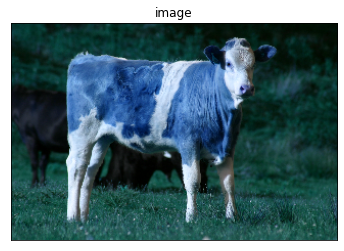

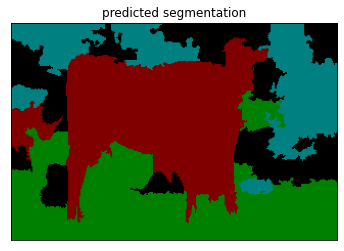

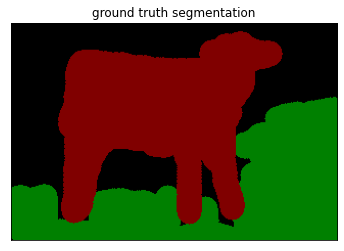

In [19]:
##############################################################################################################################
#######################################                  Inference                 ###########################################
##############################################################################################################################

def PatchLoader(image, groundtruth, slicmap, rgb_2_label, transforms =None, N_SEG=100, n_classes=10):    
    """
    Computes patches and groundtruth and labels for a given image. 
    CAN BE USED TO GENERATE PATCHES ON THE FLY.
    """
    for Ci in list(np.unique(slicmap)): # range(N_SEG):
        bbox = segBBox(slicmap, Ci)
        if bbox is  None or ((bbox[1][0]-bbox[0][0])<2 or (bbox[1][1]-bbox[0][1])<2):
            # nonecounter+=1
            continue    
        (y1,x1), (y2,x2) = bbox
        imCi = image[y1:y2, x1:x2, :] # cropped image
        if imCi.shape[0] <2 or imCi.shape[1] < 2:
            continue
        sp_i = groundtruth[y1:y2, x1:x2, :] # seg groundtruth patch containing slic-segment Ci
        sp_i_label = BBoxclass(sp_i, rgb_2_label, N_CLASSES = n_classes) # find the argmax-class-label in this patch

        if transforms:        
            yield transforms(imCi).unsqueeze(0), torch.tensor(sp_i_label)
        else:
            yield imCi, sp_i, sp_i_label


i=20 # loading 20th image
image = cv2.imread(test_imfiles[i])[:, :, ::-1] # IMPORTANT: DONT FORGET TO CONVERT IMAGES TO RGB
groundtruth = cv2.imread(test_gtfiles[i])[:, :, ::-1]
slicmap = slic(image, n_segments=N_SEG, compactness=10)

superpix2segDict = {}
pred_segment = np.zeros(image.shape, dtype=np.uint8)

for idx, sample in enumerate(PatchLoader(image, groundtruth, slicmap, rgb_2_label, transforms = custom_transforms, N_SEG=100)):
    patch, label = to_device(sample)
    predvec = net(patch)
    _, preds = torch.max(predvec, 1)

    superpix2segDict[idx] =  preds.item()-1
    indices = (slicmap == idx)
    pred_segment[indices] = label_2_rgb[preds.item()-1] # 

plot_image(image, 'image')
plot_image(pred_segment, 'predicted segmentation')
plot_image(groundtruth, 'ground truth segmentation')


# Results:
#### -  Quantitatively, SegmentationNN has an evaluation accuracy of 86%
####  - Qualitatively, we infer that segmentation acheived by SegmentationNN has been reasonably close to groundtruth. The cyan colored false positives corresponds to 'tree' class, and as we see, the background in the image actually contains trees, even though groundtruth is labelled as 'void', showing that our classifer has a reasonable segmentation performance.

# ___________________________________________________________________________________________________________________

## Bonus Questions (20 points):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

### ATTEMPTING : [Option 2 - Paper 4] :  Feedforward semantic segmentation using zoom-out features.

In [13]:
import copy

##############################################################################################################################
#######################################         Define Conv Feature Extractor          #######################################
##############################################################################################################################

class ConvFeatureExtractor():
  def __init__(self):
    # define backbone CNN
    self.vgg16 = self.vgg16_backbone()
    self.vgg16 =self.vgg16.to(device).eval()

    # define torch transforms
    mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
    self.transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

    # indices in VGG16 where feature map outputs can be obtained
    self.output_layers = [1,4,6,9,11,13,16,18,20,23,25,27,30] 

  def vgg16_backbone(self, freeze=True):
      # load pre-trained model
      vgg16 = models.vgg16(pretrained=True) 
      # freeze weights
      if freeze:
          for param in vgg16.features.parameters():
              param.requires_grad = False
      return vgg16

    
  def extract(self, image):
    x = self.transforms(image).unsqueeze(0).to(device)
    sf=2
    feature_maps = []    
    with torch.no_grad():
      # pass through 
      convlayers, adaptivepool, linears = list(self.vgg16.children())
      for layer in convlayers:
          x = layer(x)
          if isinstance(layer, nn.MaxPool2d):
              x_out = nn.UpsamplingBilinear2d(scale_factor=sf)(x)
              sf*=2
              # print(x_out.shape)        
              feature_maps.append(x_out.squeeze().permute(1,2,0).detach().cpu().numpy())
    return feature_maps


##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################
# extract feature maps

i=20 # loading some image
image = cv2.imread(test_imfiles[i])[:, :, ::-1] # IMPORTANT: DONT FORGET TO CONVERT IMAGES TO RGB
featureExtractor = ConvFeatureExtractor()
feature_maps = featureExtractor.extract(image)

for feature in feature_maps:
    print(feature.shape)  

(224, 224, 64)
(224, 224, 128)
(224, 224, 256)
(224, 224, 512)
(224, 224, 512)


In [46]:
def convzoomoutLoader( image, groundtruth, featureextractor, rgb_2_label, to_tensor = False, N_SEG=100, n_classes=10):
    feature_maps = featureextractor.extract(image)
    slicmap = slic(image, n_segments=N_SEG, compactness=10)
    # check section 6.2- convnet zoom out features
    for Ci in list(np.unique(slicmap)): # range(N_SEG):
        Ci_indices = np.where(slicmap == Ci)        
        bbox = segBBox(slicmap, Ci)
        if not bbox:
            continue    

        # extract conv features
        phi = []
        for feature_map in feature_maps:            
            slic_features = feature_map[Ci_indices]
            phi_i = slic_features.mean(axis=0)
            phi.extend(list(phi_i))
        
        (y1,x1), (y2,x2) = bbox
        sp_i = groundtruth[y1:y2, x1:x2, :] # seg groundtruth patch containing slic-segment Ci
        sp_i_label = BBoxclass(sp_i, rgb_2_label, N_CLASSES = n_classes) # find the argmax-class-label in this patch
        if to_tensor:
            yield torch.from_numpy(np.array(phi)).unsqueeze(0), torch.from_numpy(sp_i).unsqueeze(0), torch.tensor(sp_i_label+1).unsqueeze(0) 
        else:
            yield np.array(phi), sp_i, sp_i_label


In [27]:
##############################################################################################################################
############################################  Extract ConvZoomOut Features ###################################################
##############################################################################################################################

def convzoomoutLoader( image, groundtruth, featureextractor, rgb_2_label, N_SEG=100, n_classes=10):
    feature_maps = featureextractor.extract(image)
    slicmap = slic(image, n_segments=N_SEG, compactness=10)
    # check section 6.2- convnet zoom out features
    for Ci in list(np.unique(slicmap)): # range(N_SEG):
        Ci_indices = np.where(slicmap == Ci)        
        bbox = segBBox(slicmap, Ci)
        if not bbox:
            continue    

        # extract conv features
        phi = []
        for feature_map in feature_maps:            
            slic_features = feature_map[Ci_indices]
            phi_i = slic_features.mean(axis=0)
            phi.extend(list(phi_i))
        
        (y1,x1), (y2,x2) = bbox
        sp_i = groundtruth[y1:y2, x1:x2, :] # seg groundtruth patch containing slic-segment Ci
        sp_i_label = BBoxclass(sp_i, rgb_2_label, N_CLASSES = n_classes) # find the argmax-class-label in this patch

        yield np.array(phi), sp_i, sp_i_label

def extractConvZoomoutFeatures(imfiles, gtfiles, rgb_2_label, mode='train', N_SEG=100, n_classes=10):
    out = []
    featureExtractor = ConvFeatureExtractor()
    for i in tqdm(range(len(imfiles))):
        image = cv2.imread(imfiles[i])[:, :, ::-1] # IMPORTANT: DONT FORGET TO CONVERT BGR TO RGB
        groundtruth = cv2.imread(gtfiles[i])[:, :, ::-1]
        image, groundtruth = cv2.resize(image, (224, 224)), cv2.resize(groundtruth, (224, 224))

        for data_ in convzoomoutLoader( image, groundtruth, featureExtractor, rgb_2_label, N_SEG, n_classes):
            phi, _, label = data_
            out.append([phi, label])    

    root, _ = os.path.split(imfiles[0])
    np.save(f'{root}/{mode}_convzoomout.npy', np.array(out))            

##############################################################################################################################
#################################################  Function call #############################################################
##############################################################################################################################
# [ UNCOMMENT TO EXTACT FEATURES]
extractConvZoomoutFeatures(test_imfiles, test_gtfiles, rgb_2_label, mode='test', N_SEG=100, n_classes=10)
extractConvZoomoutFeatures(train_imfiles, train_gtfiles, rgb_2_label, mode='train', N_SEG=100, n_classes=10)


100%|██████████| 192/192 [03:10<00:00,  1.01it/s]


In [28]:
import torch.utils.data as data
##############################################################################################################################
#################################################  ZoomOut Dataloader ########################################################
##############################################################################################################################
class ZoomOutData(data.Dataset):
    def __init__(self, root, mode='train'):    
        self.data = np.load(f'{root}/{mode}_convzoomout.npy', allow_pickle=True)            
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        feature, label = self.data[i]
        return feature, label+1

##############################################################################################################################
#################################################  Function call #############################################################
############################################################################################################################## 
mode= 'train'
trainset = ZoomOutData(msrc_directory, mode)
print(f"Example: Features shape {trainset[0][0].shape}, label {trainset[0][1]}" )

# check values counts of label
from collections import Counter
features = np.load(f'{msrc_directory}/{mode}_convzoomout.npy', allow_pickle=True)            
d = Counter(features[:, 1])
for x in np.unique(features[:, 1]):
    print('Class {} has occurred {} times'.format(x, d[x]))

Example: Features shape (1472,), label 2
Class -1 has occurred 3807 times
Class 0 has occurred 1361 times
Class 1 has occurred 3157 times
Class 2 has occurred 860 times
Class 3 has occurred 690 times
Class 4 has occurred 1583 times
Class 5 has occurred 295 times
Class 6 has occurred 347 times
Class 7 has occurred 822 times
Class 8 has occurred 253 times


In [29]:
##############################################################################################################################
#################################################  ZoomOut Classifier ########################################################
##############################################################################################################################
class MLPClassifier(nn.Module):
    def __init__(self, n_inputs=1472, n_outputs=10):  
        # Your code 
        super(MLPClassifier, self).__init__()
      
        self.mlp =  nn.Sequential(nn.Linear(n_inputs, 1024), 
                                  nn.ReLU(inplace=True), 
                                  nn.Dropout(0.5),
                                  nn.Linear(1024, 512), 
                                  nn.ReLU(inplace=True), 
                                  nn.Dropout(0.5),
                                  nn.Linear(512, n_outputs) )
      
    def forward(self, x):
        return self.mlp(x)

##############################################################################################################################
#################################################  ZoomOut Train Routine #####################################################
##############################################################################################################################
# load the data
trainsetz = ZoomOutData(msrc_directory, 'train')
valsetz = ZoomOutData(msrc_directory, 'test')
print(f"Number of train samples: {len(trainsetz)}")
print(f"Number of test samples: {len(valsetz)}")

# data loader
Ztrain_loader = data.DataLoader(dataset=trainsetz, batch_size=64, shuffle=True, num_workers=4)
Zval_loader = data.DataLoader(dataset=valsetz, batch_size=64, shuffle=True, num_workers=4)
print(len(Ztrain_loader), len(Zval_loader) )

net = MLPClassifier().to(device)

solver = Solver(net, learning_rate=1e-4, n_epochs=10)

# [UNCOMMENT TO TRAIN]
# solver.train(Ztrain_loader, Zval_loader)
# torch.save(net.state_dict(), 'ZoomOutNN.pth')

Number of train samples: 13175
Number of test samples: 3455
206 54


206it [00:00, 373.97it/s]

Epoch: 0/10 (206.00 iters) took 0.01 mins || Acc: 0.74 || Loss : 0.81



54it [00:00, 447.46it/s]

 Validation:  took 0.00 mins || Acc: 0.90 || Loss : 0.35



206it [00:00, 344.86it/s]

Epoch: 1/10 (412.00 iters) took 0.01 mins || Acc: 0.87 || Loss : 0.38



54it [00:00, 375.21it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.31



206it [00:00, 323.11it/s]

Epoch: 2/10 (618.00 iters) took 0.01 mins || Acc: 0.90 || Loss : 0.30



54it [00:00, 413.16it/s]

 Validation:  took 0.00 mins || Acc: 0.90 || Loss : 0.30



206it [00:00, 386.54it/s]

Epoch: 3/10 (824.00 iters) took 0.01 mins || Acc: 0.91 || Loss : 0.27



54it [00:00, 387.87it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.29



206it [00:00, 371.55it/s]

Epoch: 4/10 (1030.00 iters) took 0.01 mins || Acc: 0.92 || Loss : 0.22



54it [00:00, 417.71it/s]

 Validation:  took 0.00 mins || Acc: 0.90 || Loss : 0.28



206it [00:00, 368.75it/s]

Epoch: 5/10 (1236.00 iters) took 0.01 mins || Acc: 0.93 || Loss : 0.20



54it [00:00, 417.45it/s]

 Validation:  took 0.00 mins || Acc: 0.90 || Loss : 0.31



206it [00:00, 379.21it/s]

Epoch: 6/10 (1442.00 iters) took 0.01 mins || Acc: 0.94 || Loss : 0.17



54it [00:00, 383.32it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.32



206it [00:00, 373.51it/s]

Epoch: 7/10 (1648.00 iters) took 0.01 mins || Acc: 0.94 || Loss : 0.16



54it [00:00, 442.26it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.34



206it [00:00, 362.33it/s]

Epoch: 8/10 (1854.00 iters) took 0.01 mins || Acc: 0.94 || Loss : 0.15



54it [00:00, 383.70it/s]

 Validation:  took 0.00 mins || Acc: 0.90 || Loss : 0.33



206it [00:00, 380.91it/s]

Epoch: 9/10 (2060.00 iters) took 0.01 mins || Acc: 0.95 || Loss : 0.12



54it [00:00, 437.77it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.33
Done training


In [54]:
##############################################################################################################################
#######################################         Load weights and evaluate          ###########################################
##############################################################################################################################
net.load_state_dict(torch.load('ZoomOutNN.pth'))
solver.evaluate(Zval_loader)

54it [00:00, 441.62it/s]

 Validation:  took 0.00 mins || Acc: 0.89 || Loss : 0.33


(0.33195401245245226, 0.8896795709927877)

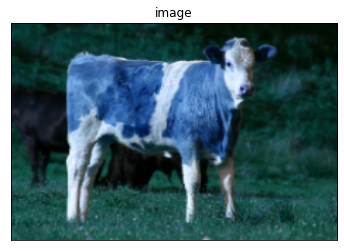

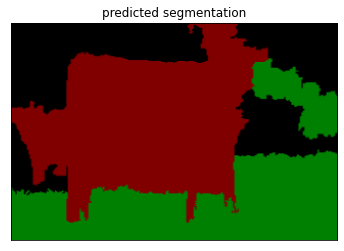

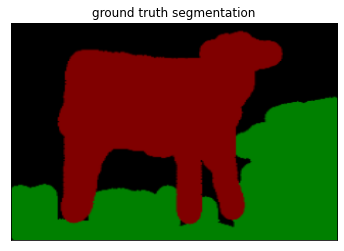

In [51]:
image = cv2.imread(test_imfiles[i])[:, :, ::-1] # IMPORTANT: DONT FORGET TO CONVERT BGR TO RGB
groundtruth = cv2.imread(test_gtfiles[i])[:, :, ::-1]
h,w = image.shape[:2]
image, groundtruth = cv2.resize(image, (224, 224)), cv2.resize(groundtruth, (224, 224))
slicmap = slic(image, n_segments=N_SEG, compactness=10)


superpix2segDict = {}
pred_segment = np.zeros(image.shape, dtype=np.uint8)
for idx, data_ in enumerate(convzoomoutLoader( image, groundtruth, featureExtractor, rgb_2_label, to_tensor=True, N_SEG=100, n_classes=10)):
    phi, _, label = to_device(data_)

    predvec = net(phi)
    _, preds = torch.max(predvec, 1)
    superpix2segDict[idx] =  preds.item()-1
    indices = (slicmap == idx)
    pred_segment[indices] = label_2_rgb[preds.item()-1] # 
  
plot_image(cv2.resize(image, (w,h)), 'image')
plot_image(cv2.resize(pred_segment, (w,h)), 'predicted segmentation')
plot_image(cv2.resize(groundtruth, (w,h)), 'ground truth segmentation')

# Results: 
#### - Quantitatively we noticed that ZoomOutNN had an evaluation accuracy of 89%. We obtain 3% improvement by using Zoomout features, that are obtained from multi resolution feature maps in the VGG-16 CNN enocder.
#### - Qualitatively, we infer that ZoomOutNN has lower false positives and relatively better segmentation performance, as we see the cow in the background was left unlabeled in the groundtruth, but our network was able to segment it with reasonable accuracy